In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3,lifelines,rpy2

cs224 
last updated: 2020-04-10 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8
lifelines 0.24.2
rpy2 3.2.6


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 41
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Estimates of the severity of coronavirus disease 2019: a model-based analysis](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext)
    * duration from onset of symptoms to death to be 17·8 days (95% credible interval [CrI] 16·9–19·2)
    * to hospital discharge to be 24·7 days (22·9–28·1).
* [Estimating SARS-COV-2 infections](https://observablehq.com/@danyx/estimating-sars-cov-2-infections)
    * it takes on average 23 days from infection to death.
    * ~5 days from infection to symptoms and ~18 days from symptoms to death so we arrive at a default value of 23 days from infection to death
* [Characteristics of COVID-19 patients dying in Italy Report based on available data on March 20th, 2020](https://www.epicentro.iss.it/coronavirus/bollettino/Report-COVID-2019_20_marzo_eng.pdf)
    * Median number of days between onset of symptoms to death: 8
    * Median number of days between onset of symptoms to hospitalization: 4
* [Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30566-3/fulltext)
    * Time from illness onset to hospital admission, days	11·0 (8·0–14·0)
* [Coronavirus: how quickly do COVID-19 symptoms develop and how long do they last?](https://patient.info/news-and-features/coronavirus-how-quickly-do-covid-19-symptoms-develop-and-how-long-do-they-last)
    * ~5 days from infection to symptoms


* [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)

In [5]:
duration_onset_death_mean = 17.8
duration_onset_death_02_5_pc = 16.9
duration_onset_death_97_5_pc = 19.2

In [6]:
def fit_measure(in_array):
    loc, k, theta = in_array[0], in_array[1], in_array[2]
    dist = stats.gamma(k, loc=loc, scale=theta)
    mean = float(dist.stats('m'))
    q_02_5 = dist.ppf(0.025)
    q_97_5 = dist.ppf(0.975)
    r = (duration_onset_death_mean - mean)**2 + (duration_onset_death_02_5_pc - q_02_5)**2 + (duration_onset_death_97_5_pc - q_97_5)**2
    return r

In [7]:
gamma_loc   = 2.0
gamma_k     = 3.0
gamme_theta = 3.0

In [8]:
l = fit_measure(np.array([gamma_loc, gamma_k, gamme_theta]))
l

236.40274873031794

In [9]:
r = scipy.optimize.minimize(fit_measure, np.array([gamma_loc, gamma_k, gamme_theta]), method='Nelder-Mead', tol=0.1)
gamma_loc   = r.x[0]
gamma_k     = r.x[1]
gamme_theta = r.x[2]
print(gamma_loc, gamma_k, gamme_theta)
r

14.893998550302967 25.668385368738527 0.11661697412505936


 final_simplex: (array([[14.89399855, 25.66838537,  0.11661697],
       [14.88129625, 25.6250824 ,  0.11762834],
       [14.8644492 , 25.67040316,  0.1177947 ],
       [14.92873074, 25.7383073 ,  0.11524772]]), array([0.01317712, 0.01323173, 0.01338485, 0.0134103 ]))
           fun: 0.01317711608372878
       message: 'Optimization terminated successfully.'
          nfev: 98
           nit: 54
        status: 0
       success: True
             x: array([14.89399855, 25.66838537,  0.11661697])

In [10]:
dist = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta)
gamma_mean = float(dist.stats('m'))
gamma_q_02_5 = dist.ppf(0.025)
gamma_q_97_5 = dist.ppf(0.975)
gamma_mean, gamma_q_02_5, gamma_q_97_5

(17.8873679826812, 16.843433590738254, 19.151583132802926)

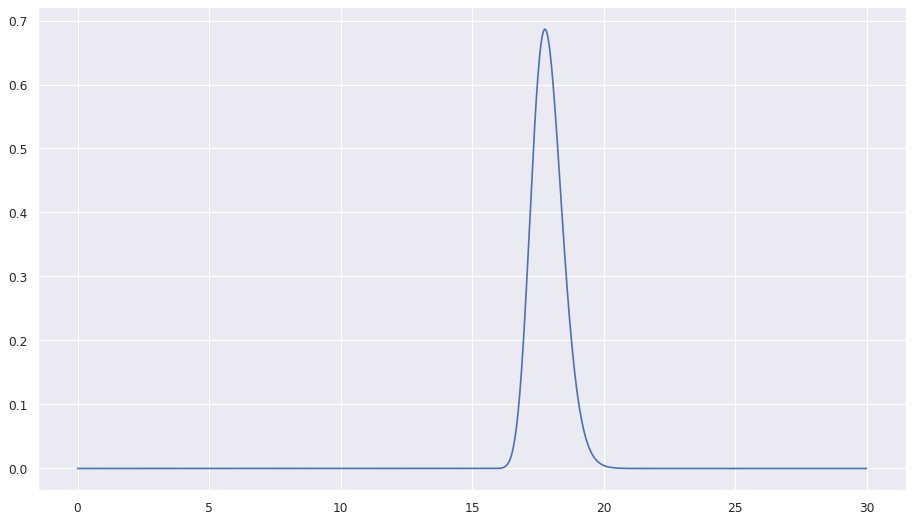

In [11]:
x = np.linspace(0.0,30.0,1000)
y = stats.gamma(gamma_k, loc=gamma_loc, scale=gamme_theta).pdf(x)
fig=plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.plot(x,y)

(3.31, 3.18, 3.44, 3.26, 9.696409634308136)


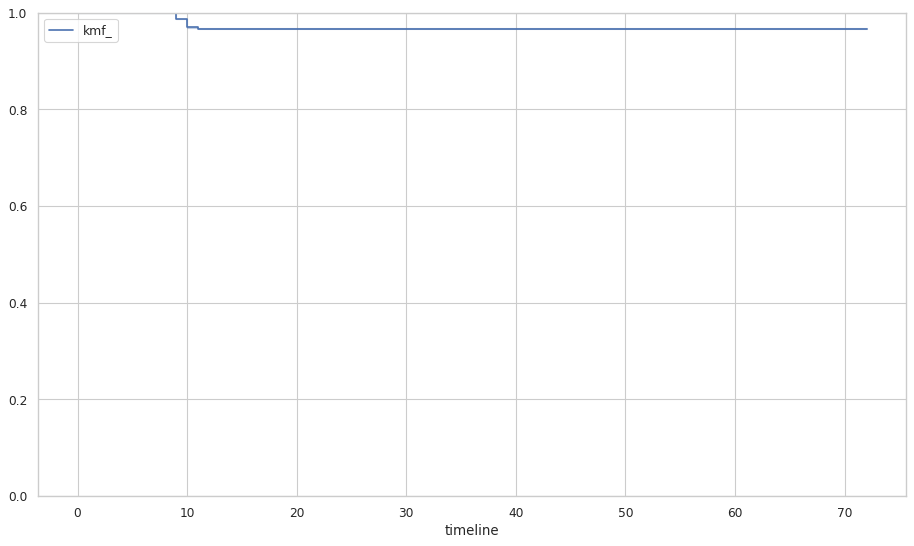

In [12]:
germany_mortality_analysis = covid19.MortalityAnalysis('Germany', first_date=pd.to_datetime('2020-03-09'), init_add=1000)
germany_mortality_analysis.fit()
print(germany_mortality_analysis.death_rate())
germany_mortality_analysis.plot()

In [13]:
germany_mortality_analysis.df.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-04-05,95950,26469,1452,4636,325,133
2020-04-06,98945,36081,1578,2995,9612,126
2020-04-07,103036,38287,1814,4091,2206,236
2020-04-08,108193,43656,2070,5157,5369,256
2020-04-09,112638,52407,2312,4445,8751,242


In [14]:
germany_mortality_analysis.project_death_and_hospitalization()

,expected_death,today_death,delta_death,expected_death_2,delta_death_across_days,delta_days,required_ventilator_capacity
0,3761.0,2312,1449.0,3410.0,162.0,21,8525.0


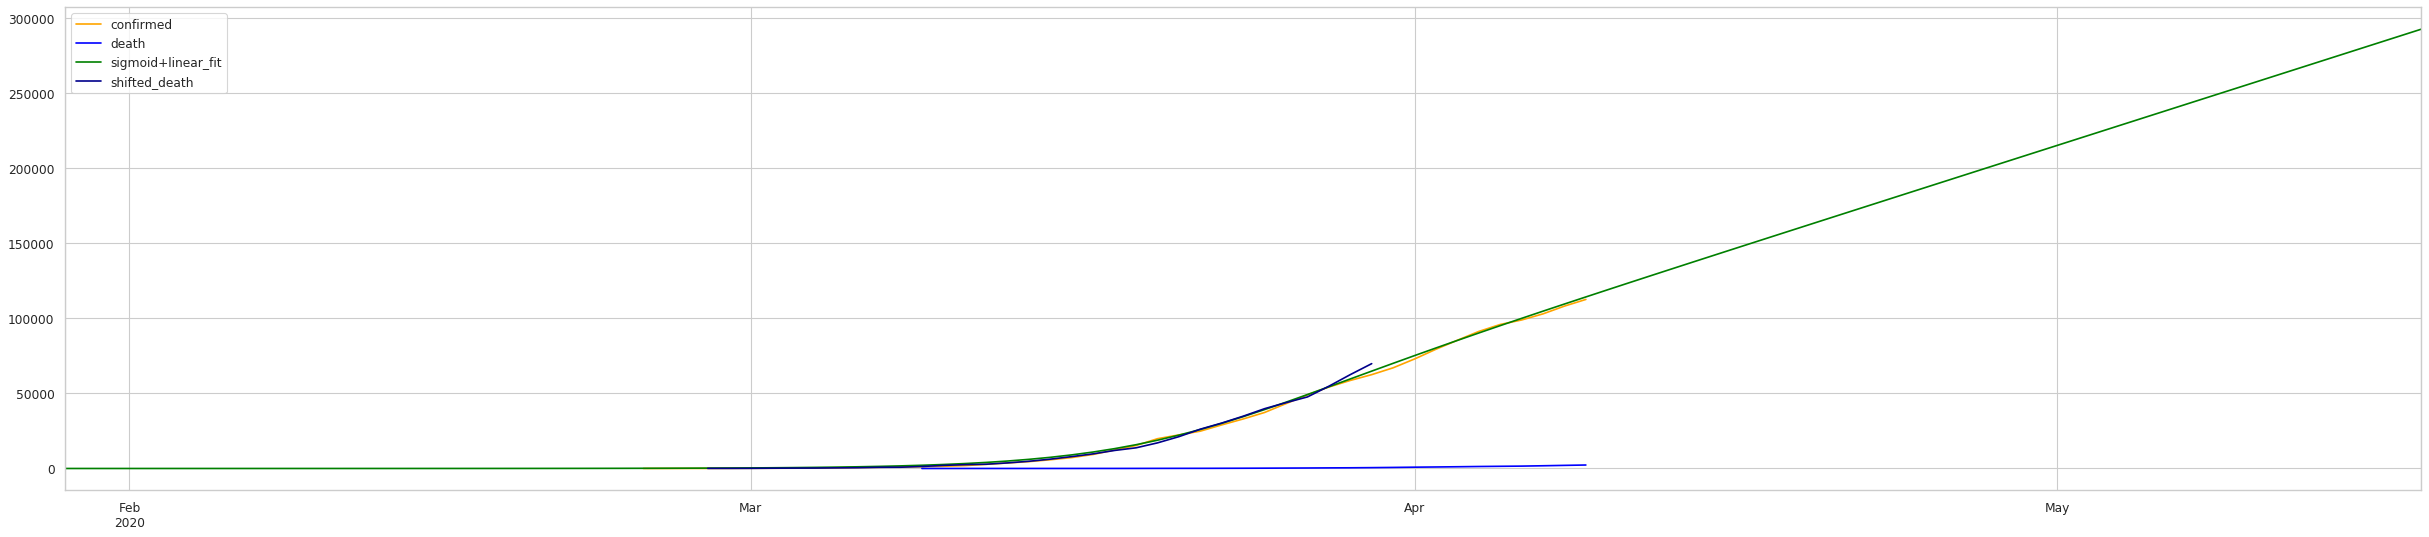

In [15]:
fig = plt.figure(figsize=(38, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ldf = germany_mortality_analysis.df[['confirmed']]
ldf = ldf[ldf.index >= pd.to_datetime('2020-02-25')]
ldf.plot(ax=ax, color=['orange'])
ldf = germany_mortality_analysis.df[['death']]
ldf = ldf[ldf.death > 0]
ldf.plot(ax=ax, color=['blue'])
germany_mortality_analysis.prediction_fit_df[[germany_mortality_analysis.prediction_fit_label_fit]].plot(ax=ax, color=['green'])

ldf = germany_mortality_analysis.df[['death']]
ldf = ldf[ldf.death > 0].copy()
ldf = ldf / float(germany_mortality_analysis.death_rate()[0] / 100.0)
ldf.columns = ['shifted_death']
ldf.index = ldf.index + pd.Timedelta(days=-int(np.round(germany_mortality_analysis.delay_between_new_cases_and_death_timeshift, 0)))
ldf.plot(ax=ax, color=['darkblue'])

In [16]:
ldf1 = germany_mortality_analysis.df[['confirmed']]
ldf1 = ldf1[ldf1.index >= pd.to_datetime('2020-02-25')]

ldf2 = germany_mortality_analysis.df[['death']]
ldf2 = ldf2[ldf2.death > 0]

display_side_by_side(ldf1.head(), ldf2.head())

,confirmed
2020-02-25,17
2020-02-26,27
2020-02-27,46
2020-02-28,48
2020-02-29,79
,death
2020-03-09,2
2020-03-10,2
2020-03-11,3
2020-03-12,6


In [17]:
ldf2.iloc[0].name - ldf1.iloc[0].name

Timedelta('13 days 00:00:00')

In [18]:
gamma_mean, gamma_q_02_5, gamma_q_97_5

(17.8873679826812, 16.843433590738254, 19.151583132802926)

In [19]:
gamma_loc, gamma_k, gamme_theta

(14.893998550302967, 25.668385368738527, 0.11661697412505936)

In [20]:
gamma_loc_shift = gamma_mean - 13
gamma_loc_shift

4.8873679826812015

In [21]:
gamma_loc_shift = gamma_mean - 8
gamma_loc_shift

9.887367982681202

In [22]:
gamma_mean - gamma_loc

2.993369432378234

In [23]:
# timeshift = loc + gamma_mean - gamma_loc


In [24]:
max(0.0, -1.0)

0.0

0.03232404781859826 9.370633408721732
(3.22, 3.09, 3.35, 3.26, 9.696409634308136)


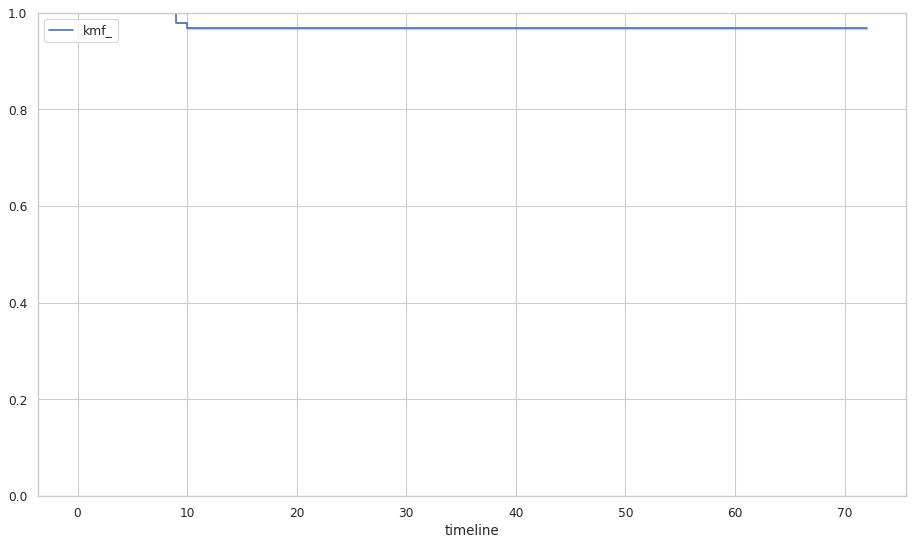

In [25]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
cfr_estimate, timeshift = covid19.calculate_delay_between_new_cases_and_death(country_name, first_date=first_date, init_add=init_add)
print(cfr_estimate, timeshift)
loc = max(timeshift - (gamma_mean - gamma_loc), 0.0)
germany_mortality_analysis2 = covid19.MortalityAnalysis(country_name, first_date=first_date, init_add=1000, gamma_distribution_parameters=dict(loc=loc, k=gamma_k, theta=gamme_theta))
germany_mortality_analysis2.fit()
print(germany_mortality_analysis2.death_rate())
germany_mortality_analysis2.plot()

In [26]:
ldf = germany_mortality_analysis2.prepend_df
ldf = ldf[ldf.index <= pd.to_datetime('2020-04-06')].copy()
ldf

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
2020-01-29,4,0,0,4,0,0
2020-01-30,8,0,0,4,0,0
2020-01-31,12,0,0,4,0,0
2020-02-01,18,0,0,6,0,0
2020-02-02,22,0,0,4,0,0
...,...,...,...,...,...,...
2020-04-02,80450,22440,1002,6494,3265,135
2020-04-03,86436,24981,1153,5986,2541,151
2020-04-04,92314,26144,1319,5878,1163,166
2020-04-05,96950,26469,1452,4636,325,133


In [27]:
gamma_loc, gamma_k, gamme_theta

(14.893998550302967, 25.668385368738527, 0.11661697412505936)

In [28]:
lldf = covid19.generate_life_lines(ldf, gamma_distribution_parameters=dict(loc=gamma_loc-5, k=gamma_k, theta=gamme_theta))
lldf

,start_date,end_date,observed_death,day_count
0,2020-01-29,2020-04-07,False,69
1,2020-01-29,2020-04-07,False,69
2,2020-01-29,2020-04-07,False,69
3,2020-01-29,2020-04-07,False,69
4,2020-01-30,2020-04-07,False,68
...,...,...,...,...
99940,2020-04-06,2020-04-07,False,1
99941,2020-04-06,2020-04-07,False,1
99942,2020-04-06,2020-04-07,False,1
99943,2020-04-06,2020-04-07,False,1


In [29]:
lldf.observed_death.sum()

1578

In [30]:
import lifelines

In [31]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(lldf.day_count, lldf.observed_death, label='kmf')

<lifelines.KaplanMeierFitter:"kmf", fitted with 99945 total observations, 98367 right-censored observations>

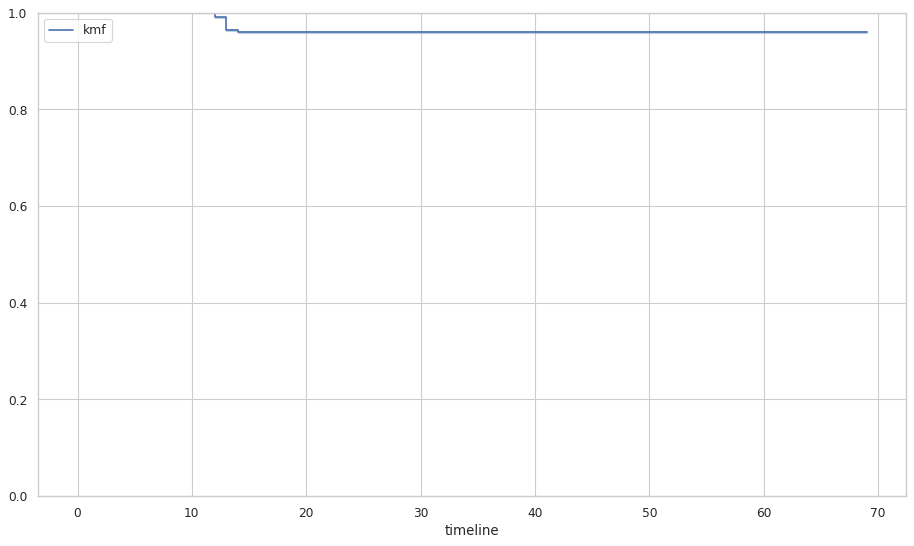

In [32]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
ax.set_ylim([0.0, 1.0])

kmf.plot(ax=ax)

In [33]:
mean = np.round(float(1 - kmf.survival_function_.iloc[-1].values) * 100, 2)
lower = np.round(float(1 - kmf.confidence_interval_.iloc[-1, 1]) * 100, 2)
upper = np.round(float(1 - kmf.confidence_interval_.iloc[-1, 0]) * 100, 2)
(mean, lower, upper)

(4.04, 3.85, 4.24)

In [34]:
lldf[lldf.observed_death].tail()

,start_date,end_date,observed_death,day_count
37564,2020-03-25,2020-04-06,True,12
37691,2020-03-25,2020-04-06,True,12
37935,2020-03-25,2020-04-06,True,12
38117,2020-03-25,2020-04-06,True,12
38176,2020-03-25,2020-04-06,True,12


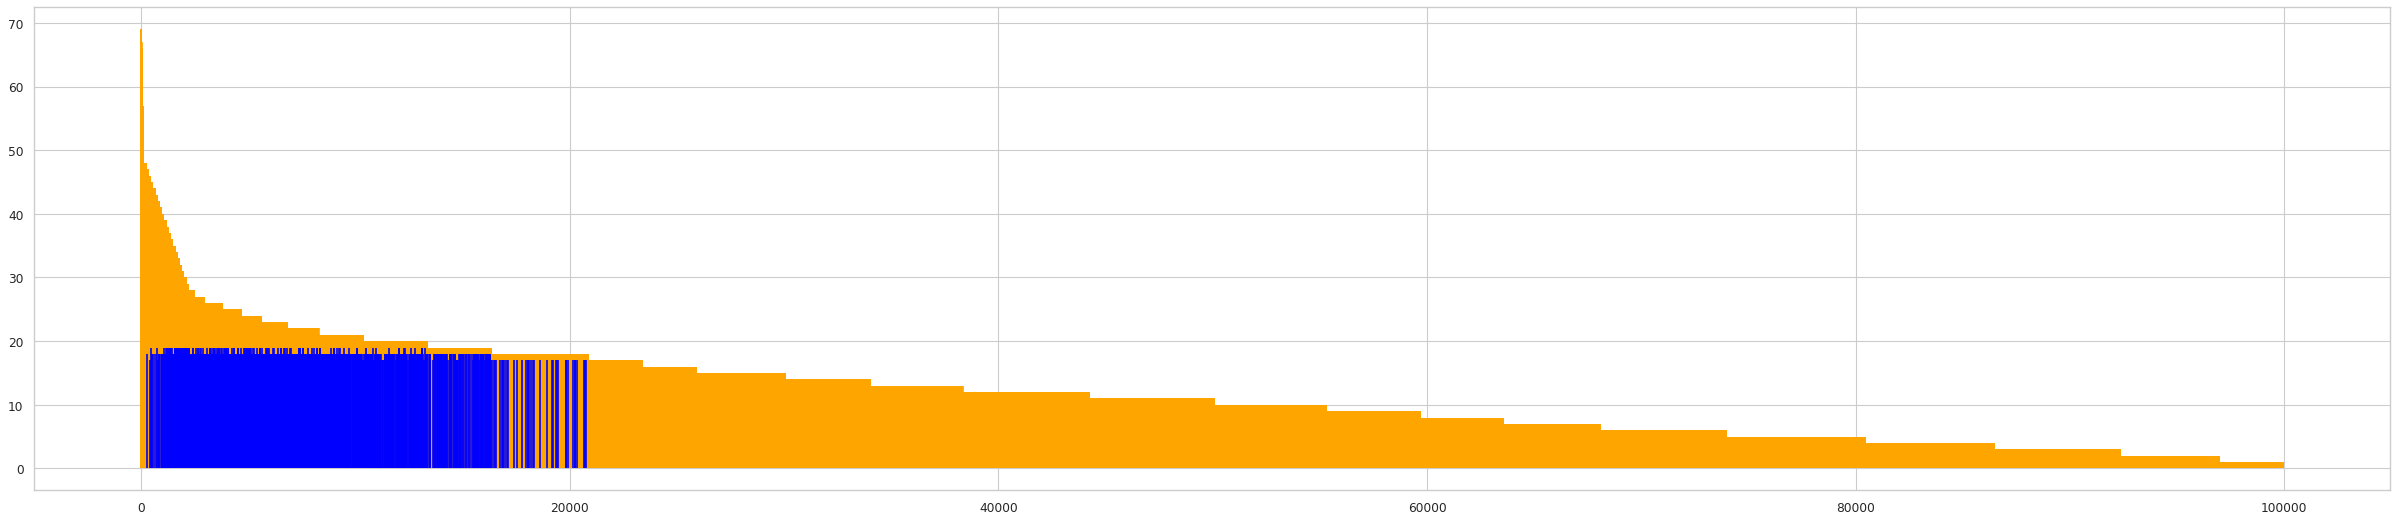

In [35]:
lldf = covid19.generate_life_lines(ldf, gamma_distribution_parameters=dict(loc=gamma_loc-0, k=gamma_k, theta=gamme_theta))
fig = plt.figure(figsize=(38, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
lldf_alive = lldf[~lldf.observed_death]
lldf_dead  = lldf[lldf.observed_death]
ax.vlines(lldf_alive.index, ymin=0, ymax=lldf_alive.day_count, color='orange')
ax.vlines(lldf_dead.index, ymin=0, ymax=lldf_dead.day_count, color='blue')

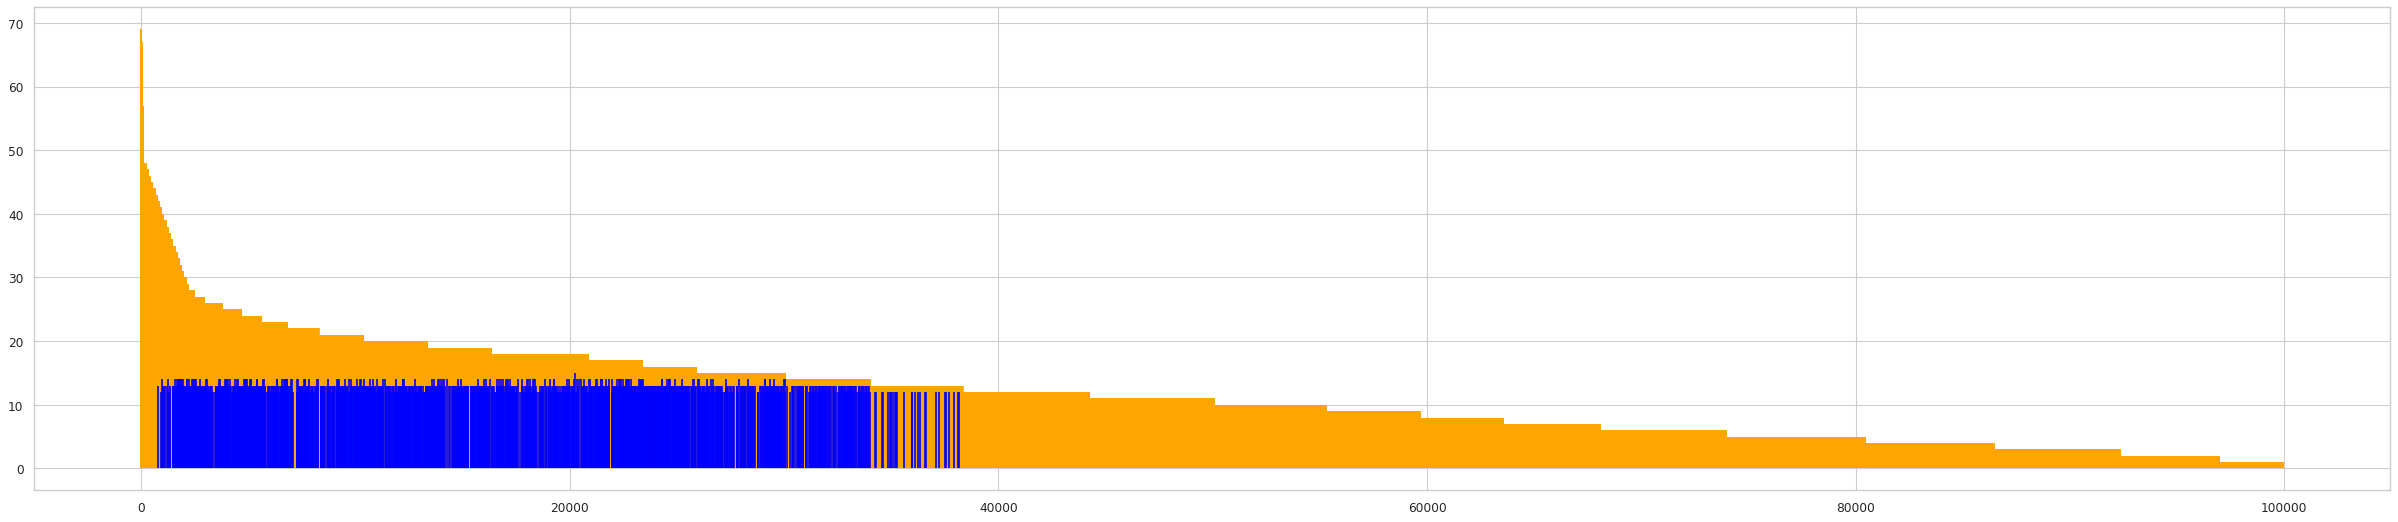

In [36]:
lldf = covid19.generate_life_lines(ldf, gamma_distribution_parameters=dict(loc=gamma_loc-5, k=gamma_k, theta=gamme_theta))
fig = plt.figure(figsize=(38, 8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(111)
lldf_alive = lldf[~lldf.observed_death]
lldf_dead  = lldf[lldf.observed_death]
ax.vlines(lldf_alive.index, ymin=0, ymax=lldf_alive.day_count, color='orange')
ax.vlines(lldf_dead.index, ymin=0, ymax=lldf_dead.day_count, color='blue')

In [37]:
import rpy2
print(rpy2.__version__)

3.2.6


In [38]:
import rpy2.robjects.packages as rpackages
baseR = rpackages.importr('base')
print(baseR.R_Version().rx('version.string'))

$version.string
[1] "R version 3.6.1 (2019-07-05)"




In [39]:
# from rpy2.rinterface import R_VERSION_BUILD
# print(R_VERSION_BUILD)

In [40]:
import IPython.display
import rpy2, rpy2.robjects, rpy2.robjects.pandas2ri, rpy2.rinterface, rpy2.robjects.packages, rpy2.interactive, rpy2.robjects.lib.ggplot2, rpy2.robjects.lib.grdevices
rpy2.robjects.pandas2ri.activate()

from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('LexisPlotR',)

# R vector of strings
from rpy2.robjects.vectors import StrVector

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/lib/ggplot2.py:72: UserWarning: This was designed againt ggplot2 version 3.2.1 but you have 3.3.0
  'have %s' % (TARGET_VERSION, ggplot2.__version__))
/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/rpy2/robjects/vectors.py:927: UserWarning: R object inheriting from "POSIXct" but 

In [41]:
grdevices = rpy2.robjects.packages.importr('grDevices')
# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))

lexis = importr('LexisPlotR')
lexis

rpy2.robjects.packages.Package as a <module 'LexisPlotR'>

In [42]:
lexis_grid = rpy2.robjects.r['lexis.grid']
lexis_lifeline = rpy2.robjects.r['lexis.lifeline']

In [43]:
def plot_lexis(df_lifelines_individual):
    mylexis = lexis_grid(year_start = 2020, year_end = 2021, age_start = 0, age_end = 1) #  lwd = 0.1

    alpha = 1.0
    ix_present = ~df_lifelines_individual.observed_death
    ix_lost    = df_lifelines_individual.observed_death
    mylexis = lexis_lifeline(lg = mylexis , entry = df_lifelines_individual['start_date'][ix_present], exit = df_lifelines_individual['end_date'][ix_present], colour = "orange", alpha = alpha, lwd = 0.4)
    mylexis = lexis_lifeline(lg = mylexis , entry = df_lifelines_individual['start_date'][ix_lost]   , exit = df_lifelines_individual['end_date'][ix_lost]   , colour = "blue"  , alpha = alpha, lwd = 0.4, lineends = True)

    with rpy2.robjects.lib.grdevices.render_to_bytesio(grdevices.png, width=1.5*1024, height=1.5*896, res=90) as img:
        rpy2.robjects.r.print(mylexis)   
    IPython.display.display(IPython.display.Image(data=img.getvalue(), format='png', embed=True))

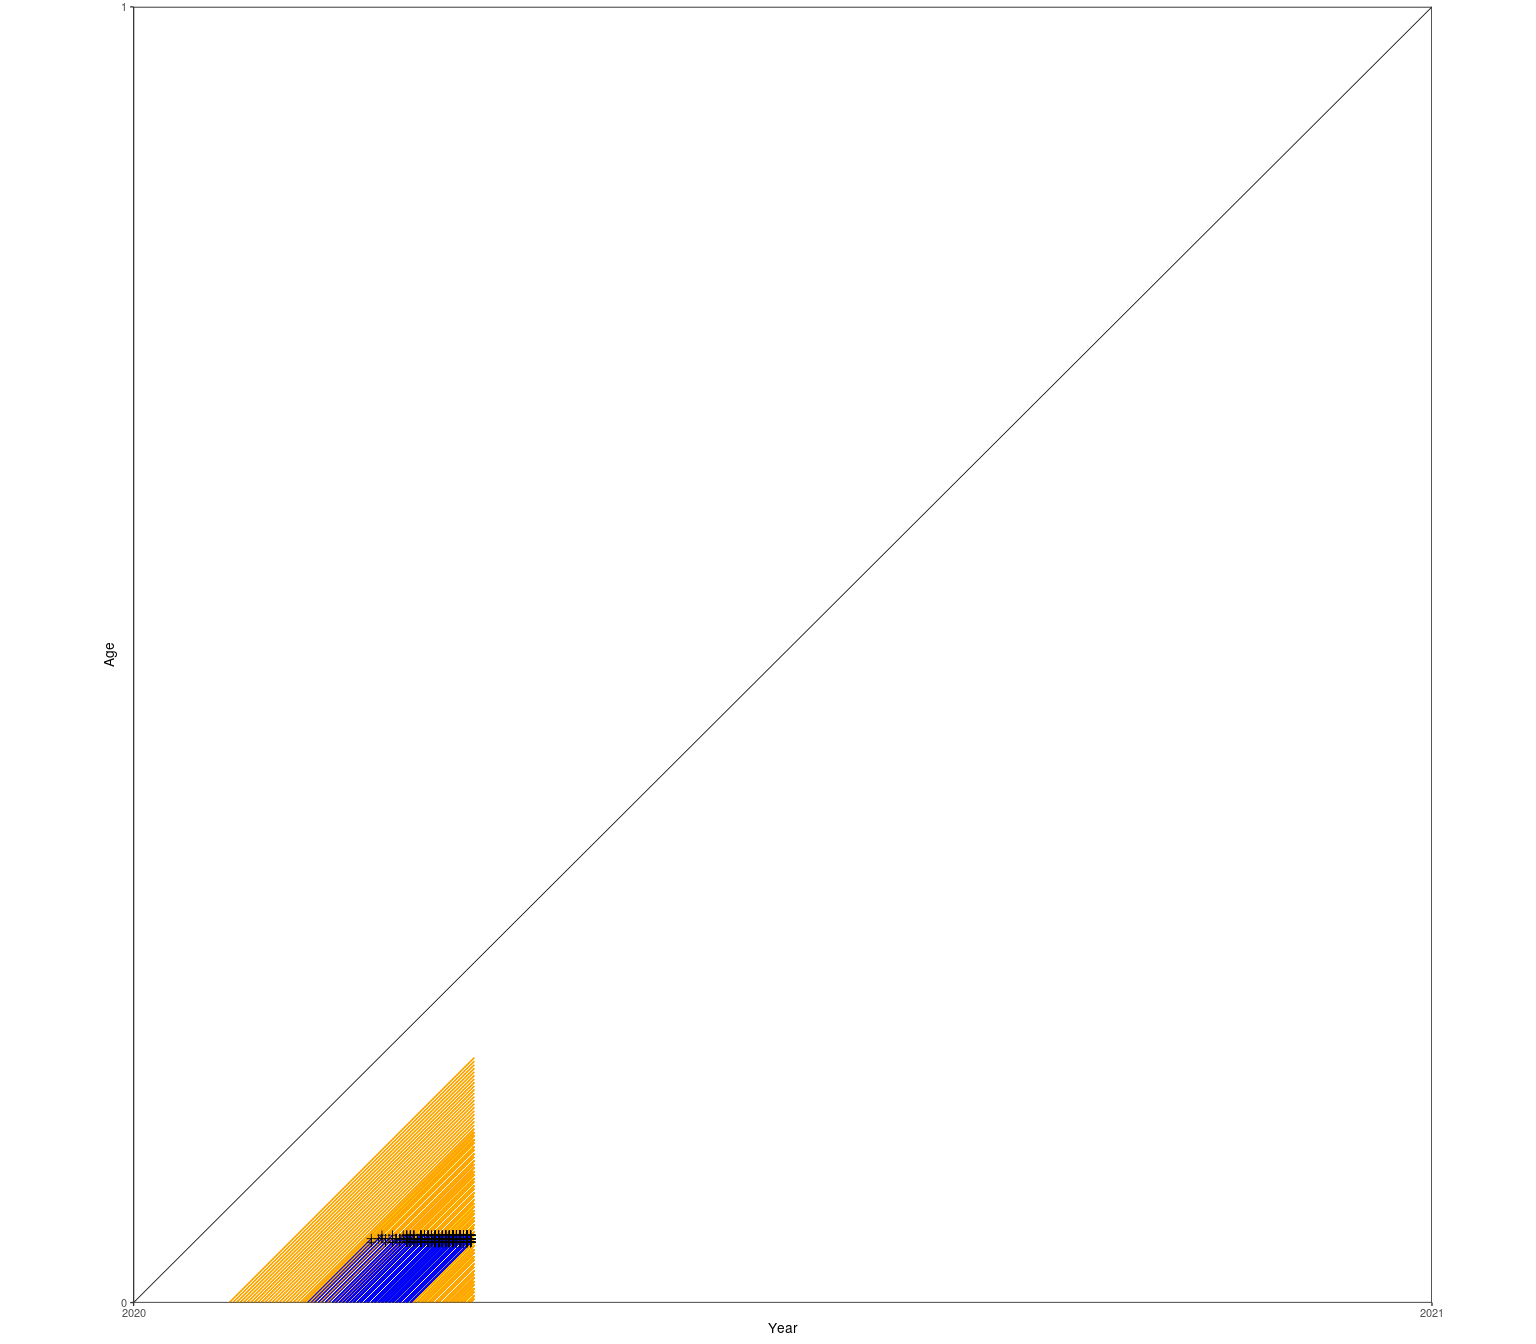

In [44]:
lldf = covid19.generate_life_lines(ldf, gamma_distribution_parameters=dict(loc=gamma_loc-0, k=gamma_k, theta=gamme_theta))
plot_lexis(lldf)

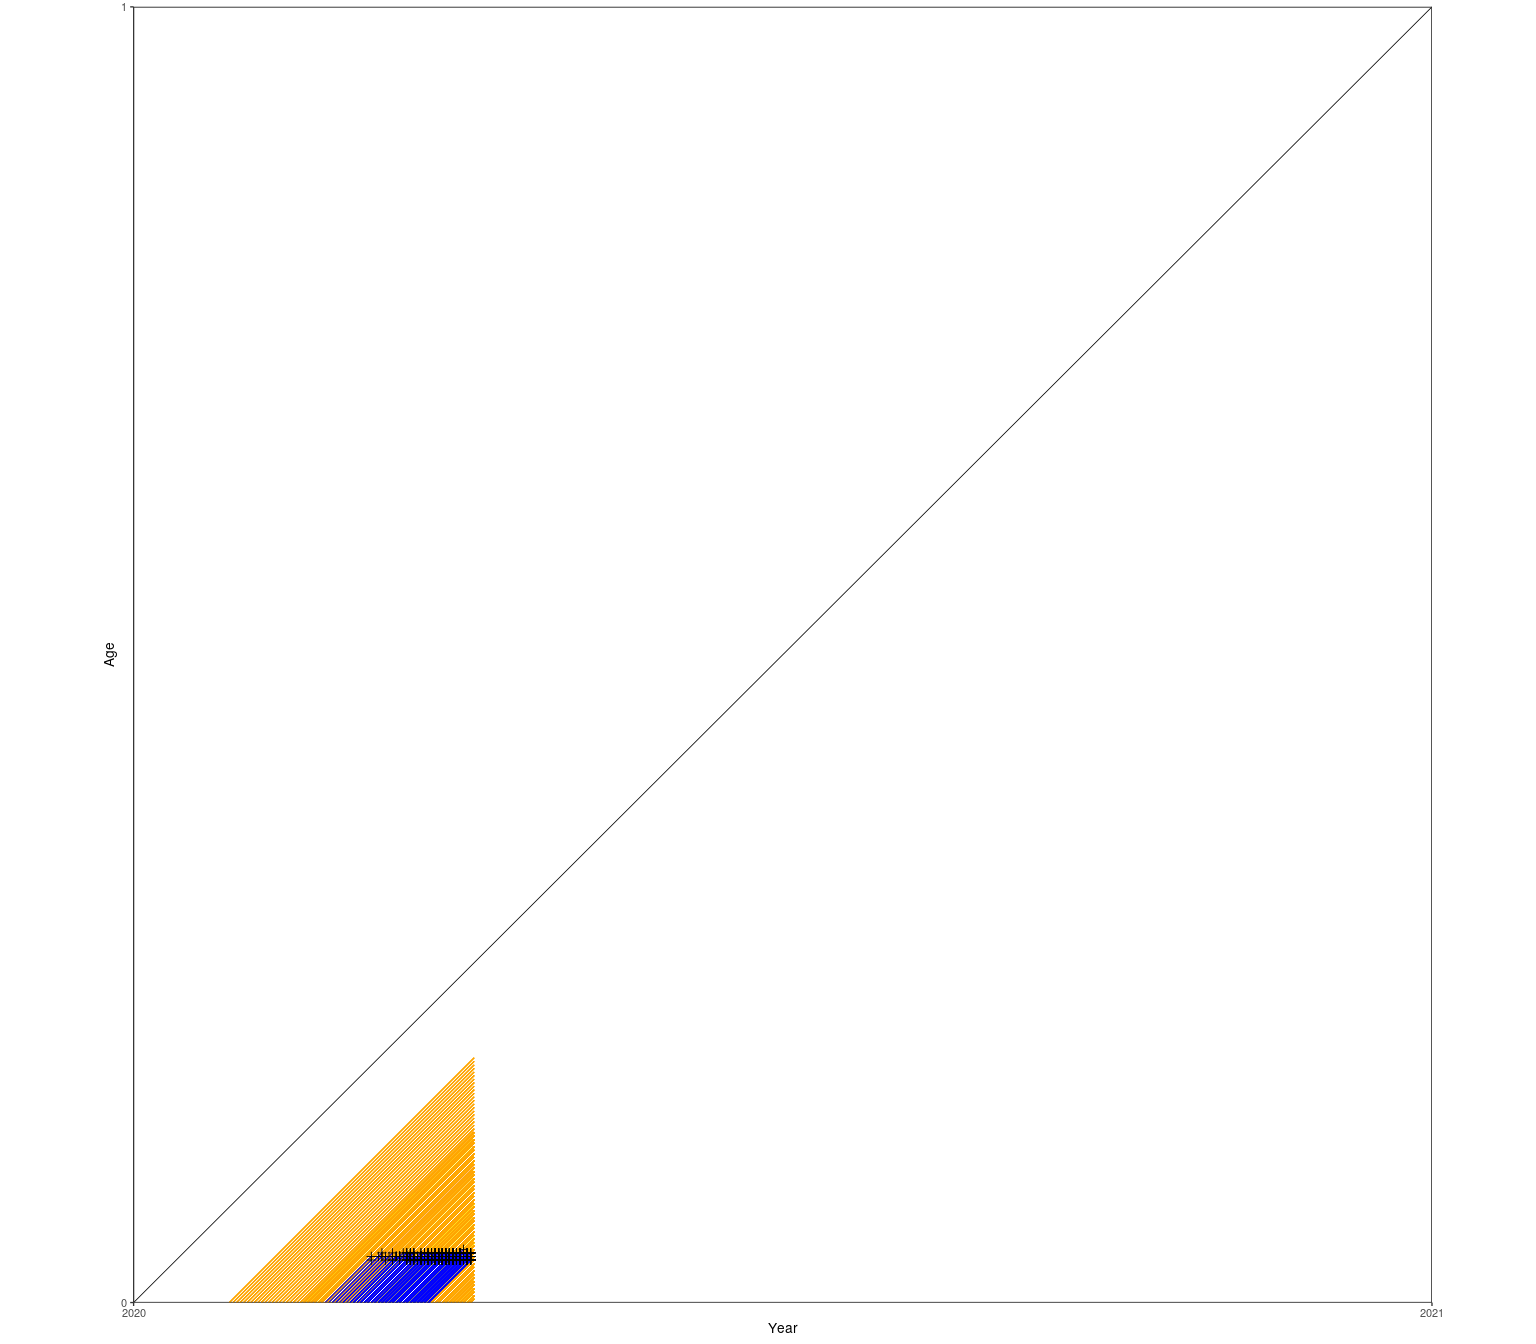

In [45]:
lldf = covid19.generate_life_lines(ldf, gamma_distribution_parameters=dict(loc=gamma_loc-5, k=gamma_k, theta=gamme_theta))
plot_lexis(lldf)

sigmoid+linear 2020-05-18 00:00:00 [32756.31569272     0.24542165    -3.72501745 19638.61483769] 0.04482483253939229


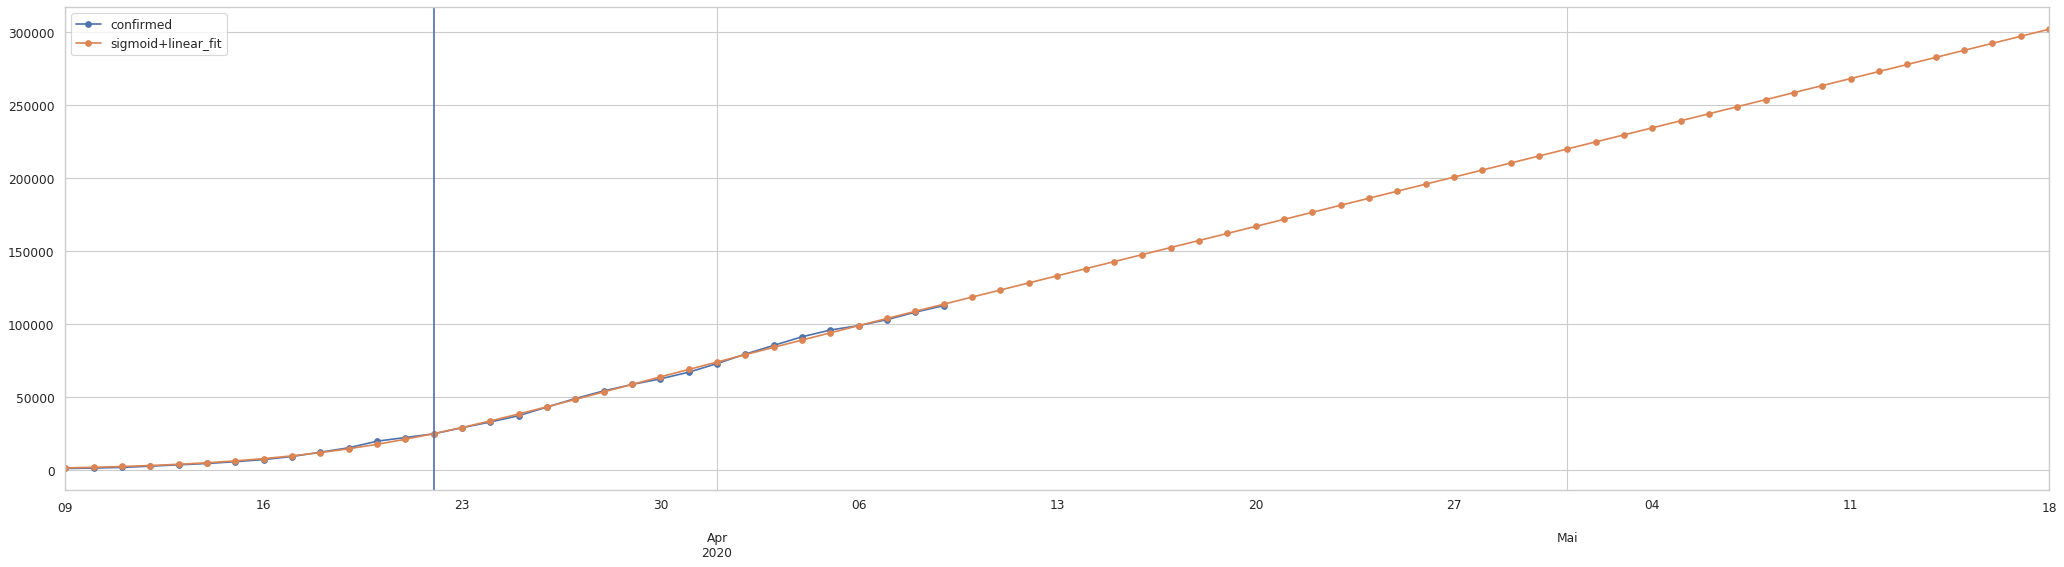

In [46]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add)
print(label, ldf.index[-1], lpopt, lgrowthRate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

In [47]:
ldf.tail()

,x,confirmed,sigmoid+linear_fit,sigmoid+linear_fit_diff
2020-05-14,67.0,NaN,282524.751559,4819.752096
2020-05-15,68.0,NaN,287344.501277,4819.749717
2020-05-16,69.0,NaN,292164.249133,4819.747856
2020-05-17,70.0,NaN,296983.995533,4819.746400
2020-05-18,71.0,NaN,301803.740793,4819.745261


In [48]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
covid19.calculate_delay_between_new_cases_and_death(country_name, first_date=first_date, init_add=init_add)

array([0.03232405, 9.37063341])

sigmoid 2020-04-12 00:00:00 [14350.32961458     0.20569832    -2.90468878] 0.010223236574044892


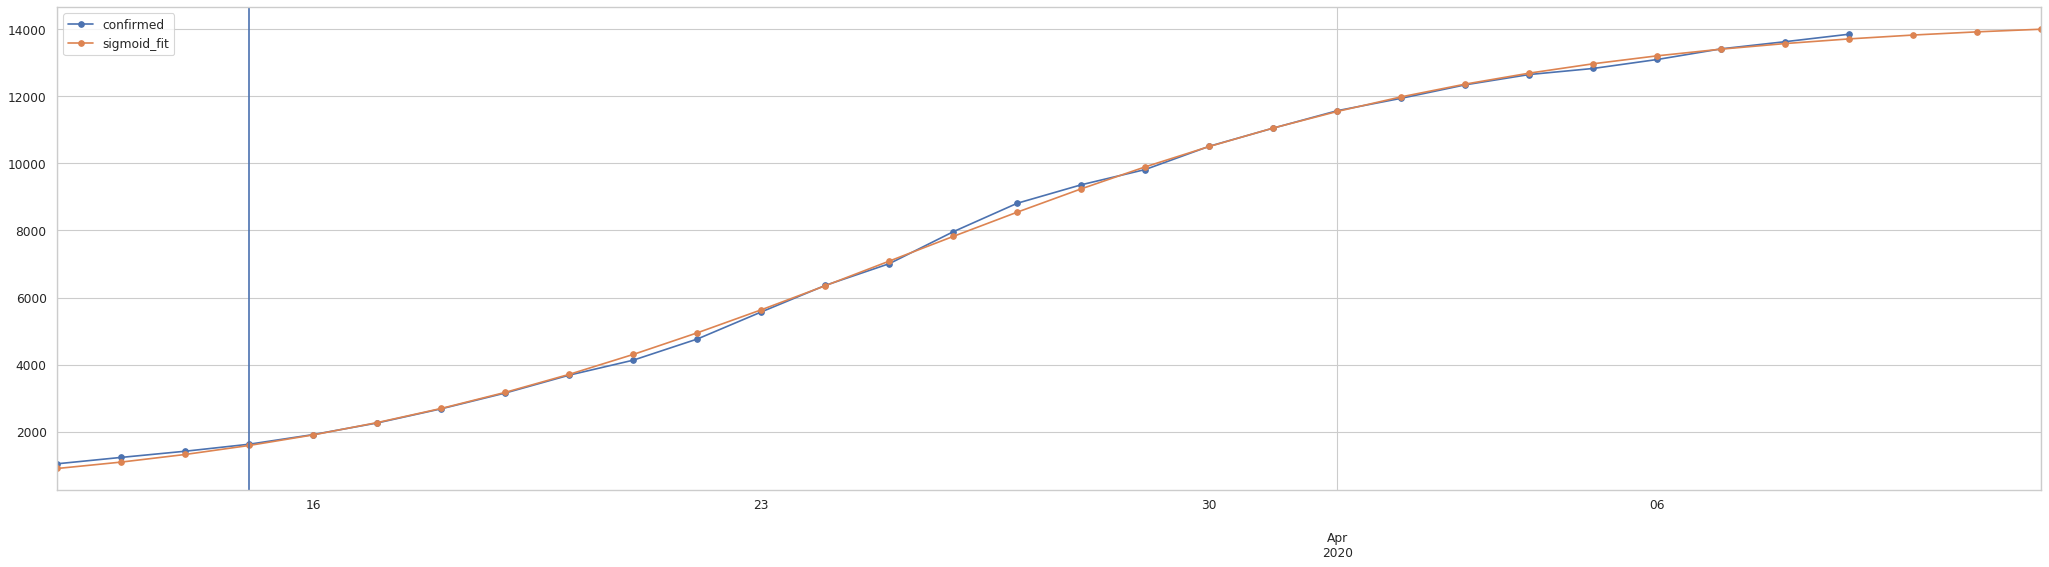

In [49]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 0, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add) # , new_confirmed_threshold=10.0
print(label, ldf.index[-1], lpopt, lgrowthRate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

sigmoid 2020-05-18 00:00:00 [350.97260087   0.23105626  -5.30500305] 0.051598920068677945


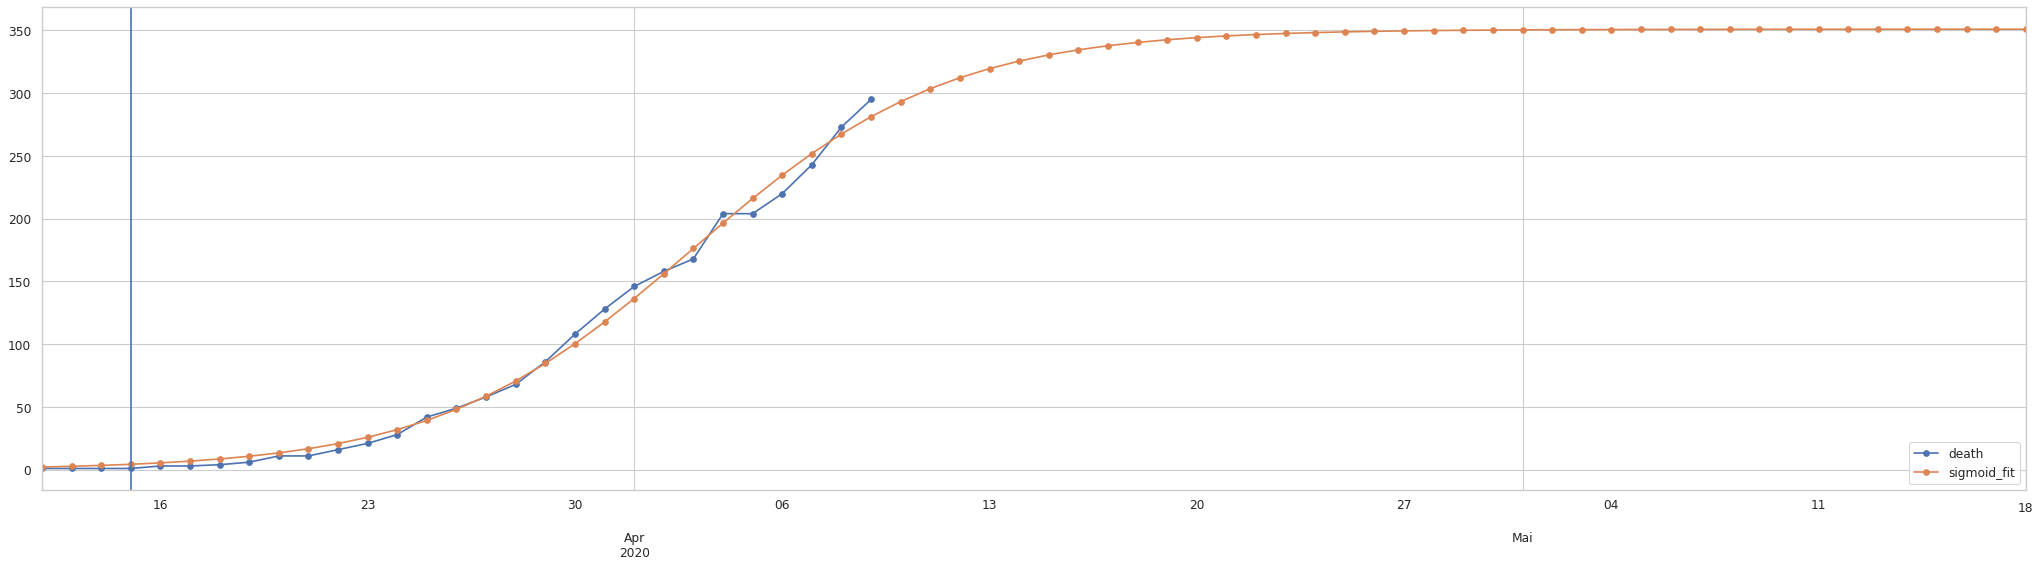

In [50]:
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-02-19'), 600, datetime.datetime(2020, 3, 15)
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
# country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 0, datetime.datetime(2020, 3, 15)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, first_date=first_date, init_add=init_add, fit_column='death', new_confirmed_threshold=0.0) # , new_confirmed_threshold=10.0
print(label, ldf.index[-1], lpopt, lgrowthRate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['death', label + '_fit']].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

In [51]:
country_name, first_date, init_add, restriction_start_date = 'Austria', pd.to_datetime('2020-03-12'), 600, datetime.datetime(2020, 3, 15)
covid19.calculate_delay_between_new_cases_and_death(country_name, first_date=first_date, init_add=init_add)

array([0.02566408, 9.45371412])